### Hamiltonian-Learning to predict the density evolution on a lattice sub-system 
We use the Hubbard dimer, a 4-mode Fermionic system, to illustrate Hamiltonian learning for predicting sub-system reduced variable time evolution. The main premise is the following: Given that we somehow are only able to observe the dynamics of a reduced subsystem variable (such as some compnents of the reduced density matrix (RDM) on a sub-set of lattice sites) and if we additionally know that the observed evolution is the result of time-evolving the full quantum system from a particular starting state (optionally under a fixed external driving), we aim to learn a Hamiltonian that lives on a dilated system (namely the observed sub-system + auxiliary environment) which under unitary evolution reproduces the reduced variable dynamics. This is a useful premise if the reduced variable dynamics we are attempting to re-produce is such that the dilated system needed to model it is smaller (or simpler in some sense) than the original quantum system required for a full description. This type of scenario may arise in some spectroscopy applications where experimental probes directly access only a small set of reduced variables (such as the electron density response). More generally the question of whether arbitrary time-series output by stochastic classical or quantum processes can be generated in a Hamiltonian-learning type setting has been considered in this recent paper: https://arxiv.org/abs/2204.06150

In this particular example we will conisder the Hubbard dimer at half filling which (without using explicit symmetry reductions) requires 4-qubits to model under a Jordan-Wigner type mapping. For a given starting state of the full dimer, we will consider the time dependent density evolution on one of the 4 modes (a one-qubit subsystem) and attempt to re-construct the dynamics using an auxiliary dilated system with only 2-qubits. 

Perform some necessary imports

In [1]:
import sys
sys.path.append('./modules')
import numpy as np
from Lattices import Vector, PeierlsDimerLattice
from LatticeSolver import LatticeSolver
from cVQD import VQD
import scipy.linalg as sl
from scipy.optimize import shgo, differential_evolution, dual_annealing, minimize
import matplotlib.pyplot as plt
from qiskit.opflow import StateFn, OperatorStateFn, PrimitiveOp, PauliExpectation, CircuitStateFn, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, X, Y, Z, I, Plus, Minus, Zero, One
from qiskit import QuantumCircuit
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.circuit.library import UCC
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

### Part-I: Data Generation
In the first part we generate the observed data, namely the density evolution on a particular mode (spin-orbial) from a time evolution of the dimer.  The starting state of the dimer is an equal superposition of all 3 eigenstates in spin-singlet sector of the haf-filled case. The eigenstates of the dimer can be obtained using an excited stated method like variational quantum deflation (VQD).  The time-evolution case we consider is unitary under the field-free Hamiltonian. 

Define the dimer parameters

In [2]:
### Construct lattice
num_nodes = 2
num_particles=2
hopping_parameter=0.5
onsite_interaction=1.0
vext=[-0.5,0.5]

Setup a 4-qubit quantum circuit which employs the UCC ansatz to represent dimer states

In [3]:
init_qc = QuantumCircuit(4)
init_qc.x(0)
init_qc.x(3)
jwcon = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=False)
wf_anz = UCC(excitations='sd', qubit_converter=jwcon, num_particles=(1,1), 
                    num_spin_orbitals=4, reps=2, initial_state=init_qc, 
                    preserve_spin=False, generalized=True)
wf_anz.draw()

┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘

Declare UCC parameters for the eigenstates of the dimer in N=2 (half-filled) sector from say a previously computed VQD result. These can then be used to initialize the circuits for full time evolution of the dimer

In [4]:
state_params = np.array([[-0.72885322,  0.07885663,  4.91877647, -0.38253978,  0.97294708,
         0.31237152],
       [ 1.12454993,  0.67023044, -2.81562309,  0.40598037,  0.35952793,
        -0.00779557],
       [ 0.43945367,  0.28753012, -5.98438076, -0.16052016,  0.14454991,
         1.10183132],
       [ 0.90222314, -0.35993084,  5.80736823,  0.95892511,  0.58091956,
         0.67334924],
       [-0.38995118,  0.90255855, -6.28318531,  1.05968074,  0.95970726,
         1.07548067],
       [ 1.17486392,  0.95599896,  1.34829664,  0.88084189,  0.31582255,
         0.71041831],
       [ 0.3107818 , -0.08698314,  6.18687168,  0.39713571,  0.71426631,
         0.18404872],
       [-0.95955198, -0.04784911, -0.61271859, -0.32921034, -0.18009263,
         1.12167548],
       [ 0.28943381, -0.59501204, -4.65852106, -0.48479905,  0.81909275,
         0.62684101],
       [ 0.88226826,  0.81095431,  6.28318531,  0.42238321,  0.94820027,
         0.71013959]])
eig_energies = [-0.8019377357983377, -3.8861500000000006e-13, 4.9128710000000004e-12, 3.333279999999999e-12, 0.5549581320866167, 2.2469796037127177]


Define a class which implements functionality for Trotter or Matrix evolution of the dimer within a Qiskit circuit model. qiskit.opflow based constructs are primarily used for this. 

In [6]:
class PeierlsDimerEvolve(PeierlsDimerLattice):
    
    def __init__(self, num_particles: float, hopping_parameter: float, onsite_interaction: float, vext: Vector, vpA: float) -> None:
        super().__init__(num_particles, hopping_parameter, onsite_interaction, vext, vpA)
        self.wfn_anz = None
        self.wfn_start = None
        self.wfn_evolved = None
        self.eig_spectrum = None
        self.eig_states = None
        self.num_sector_states = None
        self.vqdi = None
        self.ndim = None
        self.evo_time = None
        self.trotterized_op = None

    def update_ops(self, vpA: float):
        self.vPA = vpA
        self.t = self.hopping_parameter*np.exp(-(1j)*vpA)
        self.setupOps()
        self.setupQubitOps()

    def load_eigensystem(self,eigs,states,wfn_anz):
        self.eig_states = states
        self.eig_spectrum = eigs
        self.wfn_anz = wfn_anz
        self.num_sector_states = len(self.eig_spectrum)
        self.vqdi = VQD([self.qH], self.wfn_anz,  self.num_sector_states-1, states=self.eig_states)
        

    def set_starting_state(self,coeffs):
        assert len(coeffs) == self.num_sector_states
        coeffs = coeffs/np.linalg.norm(coeffs)
        p_vec = list(self.vqdi.wf_circ_op.parameters)[0].vector
        
        for ist in range(len(coeffs)):
            params = self.eig_states[:,ist]
            p_dict = {p_vec: params}
            wf = self.wfn_anz.bind_parameters(p_dict)
            if ist == 0:
                self.wfn_start = coeffs[ist] * StateFn(wf)
            else:
                self.wfn_start = self.wfn_start + coeffs[ist] * StateFn(wf)
        print(f'Circuit rep of initial state: {repr(self.wfn_start)}')
        #convert to vector state function
        self.wfn_start = self.wfn_start.eval()
        print(f'Vector state Fn rep of initial state {self.wfn_start}')
        self.wfn_evolved = self.wfn_start

    def setup_fixedH_trotter_evolution(self):
        self.evo_time = Parameter('θ')
        evolution_op = ((-1.0)*self.evo_time*self.qH).exp_i()
        dimer_evo = evolution_op @ self.wfn_start
        self.trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=4)).convert(dimer_evo)

    def setup_fixedH_matrix_evolution(self):
        self.evo_time = Parameter('θ')
        evolution_op = ((-1.0)*self.evo_time*self.qH).exp_i()
        dimer_evo = evolution_op @ self.wfn_start
        self.matrixevo_op = MatrixEvolution().convert(dimer_evo)

    def get_spinorb_rdm(self, sampling, iqubit=0):
        zero_elem = 0
        one_elem = 0
        for key in sampling:
            if key[iqubit] == '0':
                zero_elem += sampling[key]
            else:
                one_elem += sampling[key]
        return [zero_elem, one_elem]

        
    def fixedH_trotter_evolve(self, tt):
        nt = len(tt)
        dt = tt[1]-tt[0]
        spo_rdm = []
        self.evo_time = Parameter('θ')
        evolution_op = ((-1.0)*self.evo_time*self.qH).exp_i()
        # self.setup_fixedH_trotter_evolution()
        for i in range(nt):
            dimer_evo = evolution_op @ self.wfn_evolved
            self.trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=2)).convert(dimer_evo)
            bound_evo = self.trotterized_op.bind_parameters({self.evo_time: dt})
            self.wfn_evolved = bound_evo.eval()
            sampling = self.wfn_evolved.to_matrix_op().sample(shots=20000)
            spo_rdm.append(self.get_spinorb_rdm(sampling=sampling,iqubit=3))
        return np.array(spo_rdm)

    def fixedH_matrix_evolve(self, tt):
        nt = len(tt)
        dt = tt[1]-tt[0]
        spo_rdm = []
        self.setup_fixedH_matrix_evolution()
        for i in range(nt):
            bound_evo = self.matrixevo_op.bind_parameters({self.evo_time: tt[i]})
            self.wfn_evolved = bound_evo.eval()
            sampling = self.wfn_evolved.to_matrix_op().sample(shots=20000)
            spo_rdm.append(self.get_spinorb_rdm(sampling=sampling,iqubit=3))
        return np.array(spo_rdm)

To ensure consistency, define a "classical" counterpart class for the above class which performs trotter evolution directly using scipy routines.

In [7]:
class ClassicalPeierlsDimerEvolve(PeierlsDimerLattice):
    
    def __init__(self, num_particles: float, hopping_parameter: float, onsite_interaction: float, vext: Vector, vpA: float) -> None:
        super().__init__(num_particles, hopping_parameter, onsite_interaction, vext, vpA)
        self.wfn_start = None
        self.wfn_evolved = None
        self.eig_spectrum = None
        self.eig_states = None
        self.num_sector_states = None
        self.ndim = None

    def update_ops(self, vpA: float):
        self.vPA = vpA
        self.t = self.hopping_parameter*np.exp(-(1j)*vpA)
        self.setupOps()
        self.setupQubitOps()

    def solve_for_spectrum(self):
        latSolver = LatticeSolver(self)
        result = latSolver.classical_solve([self.qH, self.qN])
        idx_e_N = np.array([result[0][i] for i in range(len(result[0]))])
        self.eig_spectrum = idx_e_N[:,1]
        self.eig_states = result[1]
        self.num_sector_states = len(self.eig_spectrum)
        self.ndim = len(self.eig_states[0])
        print(self.eig_spectrum, self.num_sector_states, self.ndim)
        return self.eig_spectrum

    def set_starting_state(self,coeffs):
        assert len(coeffs) == self.num_sector_states
        coeffs = coeffs/np.linalg.norm(coeffs)
        self.wfn_start = np.zeros(self.ndim, dtype=complex)
        for i in range(len(coeffs)):
            self.wfn_start += coeffs[i] * self.eig_states[i]
        print(repr(self.wfn_start))
        #calculate overlap with eig_states
        for i in range(self.num_sector_states):
            ovlp_i = np.dot(self.wfn_start.conj().T,self.eig_states[i])
            print(f"overlap with state {i} is {ovlp_i}")
        #compute energy expectation of starting state:
        self.Hmat = self.qH.to_matrix()
        e_start = np.dot(self.wfn_start.conj().T,np.dot(self.Hmat, self.wfn_start))
        print(f'stating energy is {e_start}')
        self.wfn_evolved = self.wfn_start
    
    def time_evolve(self,T):
        Umat  = sl.expm(-(1j * T)*self.Hmat)
        self.wfn_evolved = np.dot(Umat, self.wfn_start)
        #calculate density matrix in eigen basis \rho_ij = < i| psi > <psi| j>

    def get_dm_element(self, ri, rj):
        ovlp_i = np.dot(self.eig_states[ri].conj().T,self.wfn_evolved)
        ovlp_j = np.dot(self.wfn_evolved.conj().T,self.eig_states[rj])
        # print(f"rho({ri},{rj}) = {ovlp_i * ovlp_j}")    
        return ovlp_i * ovlp_j

    def get_energy(self):
        #compute energy expectation of evolved state:
        return np.dot(self.wfn_evolved.conj().T,np.dot(self.Hmat, self.wfn_evolved))

    def get_site_density(self):
        rho_t = np.zeros(self.nsites)
        for iop in range(len(self.qnsite)):
            opm = self.qnsite[iop].to_matrix()
            rho_t[iop] = np.real(np.dot(self.wfn_evolved.conj().T,np.dot(opm,self.wfn_evolved)))
        return np.real(rho_t)

    def get_site_rdm(self):
        rho = np.outer(self.wfn_evolved.conj(), self.wfn_evolved)
        rho_tensor = rho.reshape((4,4,4,4))
        return np.trace(rho_tensor, axis1=0, axis2=2)

    def get_spinorb_rdm(self):
        rho = np.outer(self.wfn_evolved.conj(), self.wfn_evolved)
        rho_tensor = rho.reshape((8,2,8,2))
        return np.trace(rho_tensor, axis1=0, axis2=2)        
        

    def trotter_evolve(self,tt,At):
        nt = len(tt)
        assert len(tt) == len(At)
        dt = tt[1]-tt[0]
        ene_t = np.zeros(nt)
        rho_t = []
        left_rdm = []
        spo_rdm = []
        for i in range(nt):
            #re-build the time-dependent hamiltonian
            self.update_ops(At[i])
            self.Hmat = self.qH.to_matrix()
            Umat  = sl.expm(-(1j * dt)*self.Hmat)
            self.wfn_evolved = np.dot(Umat, self.wfn_evolved)
            left_rdm.append(self.get_site_rdm())
            spo_rdm.append(self.get_spinorb_rdm())
            ene_t[i] = np.real(self.get_energy())
            rho_t.append(self.get_site_density())
        return (np.array(spo_rdm, dtype=complex), np.array(left_rdm, dtype=object), np.array(rho_t), ene_t)


Initialize the time-evolver for a circuit based dimer model and prepare the starting state of the dimer as a linear combination of dimer singlet eigenstates.  

In [8]:
phube = PeierlsDimerEvolve(num_particles=num_particles, hopping_parameter=hopping_parameter,onsite_interaction=onsite_interaction,vext=vext,vpA=0)
phube.load_eigensystem(eig_energies, state_params, wfn_anz=wf_anz)
phube.set_starting_state([-1,0,0,0,1,1])

/Users/dasc/opt/anaconda3/envs/qmlmpi/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/lattice/models/fermi_hubbard_model.py:123: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(ham, register_length=register_length, display_format=display_format)


Circuit rep of initial state: SummedOp([CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc8112b3790>, coeff=-0.5773502691896258, is_measurement=False), CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc8112b3eb0>, coeff=0.0, is_measurement=False), CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc82101a490>, coeff=0.0, is_measurement=False), CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc8112d15b0>, coeff=0.0, is_measurement=False), CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc8112b5310>, coeff=0.5773502691896258, is_measurement=False), CircuitStateFn(<qiskit_nature.circuit.library.ansatzes.ucc.UCC object at 0x7fc811318400>, coeff=0.5773502691896258, is_measurement=False)], coeff=1.0, abelian=False)
Vector state Fn rep of initial state VectorStateFn(Statevector([ 0.00000000e+00+0.0000e+00j,  0.00000000e+00+0.0000e+00j,
              4.76000

Initialize the time-evolver for a classical numpy matrix based dimer model and prepare the starting state of the dimer as a linear combination of dimer singlet eigenstates.

In [9]:
cphube = ClassicalPeierlsDimerEvolve(num_particles=num_particles, hopping_parameter=hopping_parameter,onsite_interaction=onsite_interaction,vext=vext,vpA=0)
sp_spectrum = cphube.solve_for_spectrum()
cphube.set_starting_state([1.,0,0,0,1.,1.])

[-8.01937736e-01  5.43497209e-32  0.00000000e+00  0.00000000e+00
  5.54958132e-01  2.24697960e+00] 6 16
array([ 0.00000000e+00+0.j,  5.20991625e-16+0.j,  3.38828774e-32+0.j,
        8.69537429e-01+0.j, -2.15801797e-16+0.j,  0.00000000e+00+0.j,
       -7.43085769e-02+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        7.43085769e-02+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        4.82556867e-01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j])
overlap with state 0 is (0.577350269189626+0j)
overlap with state 1 is 0j
overlap with state 2 is 0j
overlap with state 3 is 0j
overlap with state 4 is (0.5773502691896257+0j)
overlap with state 5 is (0.5773502691896257+0j)
stating energy is (0.6666666666666665+0j)


Time evolve the circuit based dimer model and obtain a time-series for the reduced density matrix on one of the qubits. This will be the observed data.

In [10]:
#Time evolve and get rdms 
a = 2
n_periods = 30
samples_per_per = 30
T = (2*np.pi/a)*n_periods
nt = int(n_periods * samples_per_per)
dt = T/nt
tt = np.array([ i*dt for i in range(nt) ])
tt = [ i*dt for i in range(nt) ]
spo_rdm = phube.fixedH_trotter_evolve(tt)

To verify consistency, also time-evolve the matrix based dimer model and obtain a time-series for the reduced density matrix on one of the qubits.

In [12]:
#Time evolve and get rdms 
a = 2
n_periods = 30
samples_per_per = 30
T = (2*np.pi/a)*n_periods
nt = int(n_periods * samples_per_per)
dt = T/nt
tt = np.array([ i*dt for i in range(nt) ])
At = np.zeros(nt)
tt = [ i*dt for i in range(nt) ]
cspo_rdm,left_rdm,rho_t,ene_t = cphube.trotter_evolve(tt,At)

Plot the (1,1) component of the single qubit RDMs obtained from the circuit based and matrix based models. This verifies the validity of the circuit based Trotter evolution.

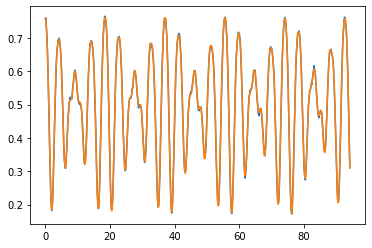

In [14]:
plt.plot(tt[:],np.real(spo_rdm[:,1]))
plt.plot(tt[:],np.real(cspo_rdm[:,1,1]))

### Part-II: Hamiltonian-Learning 
Given a time-series for the single-qubit RDM (which will be our reference RDM) obtained from evolving the full 4-qubit dimer,  in this part we construct an auxiliary system consisting of 2-qubits which aims to reproduce the diagonal components of the reference RDM.

Store the diagonal components of the circuit based single-qubit RDM obtained above for later use. 

In [18]:
rdm = np.array([ np.array(np.diag(spo_rdm[i]), dtype=complex) for i in range(len(spo_rdm))])
print(rdm[0])

[[0.2439+0.j 0.    +0.j]
 [0.    +0.j 0.7561+0.j]]


Setup a model of the 2-qubit auxiliary system. This requires us to provide a model for the 2-qubit Hamiltonian whose parameters we wish to learn. Accordingly, 2-local Hamiltonian with 9-parameters is defined in this class. Additionally we specify a cost function which is needed for optimization of the desired Hamiltonian parameters. In this instance the cost function aims to minmize the squared distance between the diagonal components of the reference and model generated RDMs over the entire trajectory. Other cost functions such as based on maximizing the fidelity may also be considered.

In [27]:
class EvolveModel:
    def __init__(self, tt, rdm_t, init_params=None) -> None:
        self.dim = 4
        self.sdim = 2
        self.edim = int(self.dim/self.sdim)
        self.wfn_start = None
        self.purify(rdm_t[0],self.edim)
        self.wfn_evolved = self.wfn_start
        if not init_params:
            self.xp = 0.5*np.random.randn(9)
        else:
            self.xp = init_params
        print(f'initial params:{self.xp}')
        self.rdm_t = rdm_t
        self.tt = tt
        self.ncall = 0
        self.rdm_pred=[]
    
    def purify(self,rdm,edim):
        dim = len(rdm)
        ddim = dim*edim
        for id in range(dim):
            p_id = np.sqrt(rdm[id,id])
            vs = np.zeros(dim)
            vs[id] = 1
            ve = np.zeros(edim)
            ve[id] = 1
            if id == 0:
                sb = p_id * StateFn(vs)^StateFn(ve)
            else:
                sb += p_id * StateFn(vs)^StateFn(ve)
        dsb = sb.to_matrix_op().to_dict_fn()
        arep = sb.to_matrix_op().to_density_matrix()
        ordm = qi.partial_trace(arep,[1])
        assert np.allclose(ordm, rdm)
        print(f'initial purification: {sb}')
        self.wfn_start = sb
        

    def calcHam(self) -> None:
        alpha = self.xp
        Hs_op = alpha[0] * FermionicOp("I_0 N_1", register_length=2, display_format='dense') + \
                alpha[1] * FermionicOp("N_0 I_1", register_length=2, display_format='dense') + \
                alpha[2] * FermionicOp("N_0 N_1", register_length=2, display_format='dense') + \
                alpha[3] *(FermionicOp("-_0 +_1", register_length=2, display_format='dense') - FermionicOp("+_0 -_1", register_length=2, display_format='dense') ) + \
                alpha[4] *(FermionicOp("+_0 +_1", register_length=2, display_format='dense') - FermionicOp("-_0 -_1", register_length=2, display_format='dense') ) + \
                alpha[5] *(FermionicOp("-_0 I_1", register_length=2, display_format='dense') + FermionicOp("+_0 I_1", register_length=2, display_format='dense') ) + \
                alpha[6] *(FermionicOp("I_0 -_1", register_length=2, display_format='dense') + FermionicOp("I_0 +_1", register_length=2, display_format='dense') ) + \
                alpha[7] *(FermionicOp("-_0 N_1", register_length=2, display_format='dense') + FermionicOp("+_0 N_1", register_length=2, display_format='dense') ) + \
                alpha[8] *(FermionicOp("N_0 -_1", register_length=2, display_format='dense') + FermionicOp("N_0 +_1", register_length=2, display_format='dense') )   
  
        self.qHs_op = phube.jw_converter.convert(Hs_op)
        self.ham = self.qHs_op.to_matrix()
        assert np.allclose(self.ham, self.ham.conj().T)
        self.evo_time = Parameter('θ')
        evo_op = (self.evo_time*self.qHs_op).exp_i()
        wfn_evo = evo_op @ self.wfn_start
        self.matrixevo_op = MatrixEvolution().convert(wfn_evo)
        self.trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=4)).convert(wfn_evo)
        # print(self.trotterized_op)

    def calcU(self, t) -> None:
        pass

    def get_system_rdm(self, sampling, iqubit=0):
        zero_elem = 0
        one_elem = 0
        for key in sampling:
            if key[iqubit] == '0':
                zero_elem += sampling[key]
            else:
                one_elem += sampling[key]
        return np.diag([zero_elem, one_elem])

    def evolve(self, t):
        bound_evo = self.matrixevo_op.bind_parameters({self.evo_time: t})
        self.wfn_evolved = bound_evo.eval()
        return self.wfn_evolved

    def cost_func(self, params):
        self.xp = params
        if self.ncall == 0:
            print(f'initial params: {self.xp}')
        self.calcHam()
        cost = 0
        for i in range(len(self.tt)):
            t = self.tt[i]
            wfn_out = self.evolve(t)
            sampling = wfn_out.to_matrix_op().sample(shots=20000)
            rdm_out = self.get_system_rdm(sampling=sampling)
            lsq = np.linalg.norm(rdm_out[0,0] - self.rdm_t[i,0,0])
            cost += lsq
        cost = np.abs(cost/len(self.tt))
        if self.ncall % 100 == 0:
             print(f'iter: {self.ncall}, cost={cost}, params={self.xp}')
        self.ncall += 1
        return cost

    def set_output_ts(self):
        self.rdm_pred=[]
        for i in range(len(self.tt)):
            t = self.tt[i]
            wfn_out = self.evolve(t)
            sampling = wfn_out.to_matrix_op().sample(shots=20000)
            rdm_out = self.get_system_rdm(sampling=sampling)
            self.rdm_pred.append(rdm_out)
        self.rdm_pred = np.array(self.rdm_pred,dtype=complex)


    def optimize(self):
        self.res = minimize(self.cost_func, self.xp, method='Nelder-Mead',options={'maxiter': 20, 'disp': True })
        # bounds = [(-1,1)]*9
        # self.res = dual_annealing(self.cost_func, bounds=bounds, x0=self.xp, maxiter=1000)
        print(self.res)
        print(f'final parameters:{self.xp}')
        self.set_output_ts()
        

#### Instantiate the learning model. 

The reference trajectory is available for 900 time steps. Use the first 300 time-steps for training the model.

The goal is to check if the model can 

    (a) reproduce the trajectory on the training data and 

    (b) predict future time-points on the remaining 2/3 of the reference data which is not used for training.

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


initial purification: VectorStateFn(Statevector([0.49386233+0.j, 0.        +0.j, 0.        +0.j,
             0.86954011+0.j],
            dims=(2, 2)))
initial params:[-0.39386402  0.31014064  0.02487933  0.71612136 -0.69975731  0.36140513
  0.8471421  -0.06514023 -0.65579789]


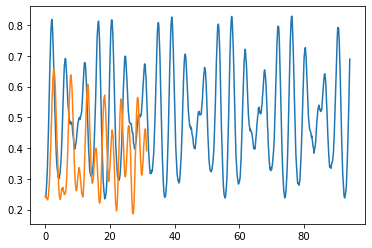

In [28]:
em = EvolveModel(tt[0:300], rdm[0:300])
em.calcHam()
em.set_output_ts()
plt.plot(tt,np.real(rdm[:,0,0]))
plt.plot(tt[0:300],np.real(em.rdm_pred[0:300,0,0]))

As seen above by instantiating with random parameters (i.e., the un-trained model) yields a predicted trajectory that looks nothing like the observed one. 

Optimizing this model takes a while and for good results requires the use of global optimizers as local optimizers can get trapped in local minima. 

Assuming we have a good starting guess (such as from a previous round of training) we can re-instantiate the model and see how the model performs on the trajectory used for training.

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


initial purification: VectorStateFn(Statevector([0.49386233+0.j, 0.        +0.j, 0.        +0.j,
             0.86954011+0.j],
            dims=(2, 2)))
initial params:[0.42419006, -0.01593614, -0.48028082, 0.9896677, -0.84485555, -0.70797138, -0.44130739, 0.26342375, 0.36292724]


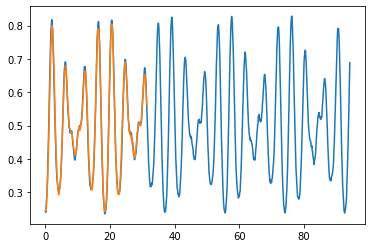

In [29]:
optimzed_guess = [ 0.42419006, -0.01593614, -0.48028082,  0.9896677 , -0.84485555, -0.70797138, -0.44130739,  0.26342375,  0.36292724 ]
em = EvolveModel(tt[0:300], rdm[0:300], init_params=optimzed_guess)
em.calcHam()
em.set_output_ts()
plt.plot(tt,np.real(rdm[:,0,0]))
plt.plot(tt[0:300],np.real(em.rdm_pred[0:300,0,0]))

As can be seen, with the optimized parameters, the model reproduces the training trjectory data well. One can optinally re-optimize the model starting from this guess.

#### Optimize the parameters of the Hamiltonian to be learnt

In [30]:
em.optimize()

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


initial params: [ 0.42419006 -0.01593614 -0.48028082  0.9896677  -0.84485555 -0.70797138
 -0.44130739  0.26342375  0.36292724]


Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


iter: 0, cost=0.011370166666666681, params=[ 0.42419006 -0.01593614 -0.48028082  0.9896677  -0.84485555 -0.70797138
 -0.44130739  0.26342375  0.36292724]


Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Mat

 final_simplex: (array([[ 0.42419006, -0.01593614, -0.48028082,  0.9896677 , -0.84485555,
        -0.70797138, -0.44130739,  0.26342375,  0.36292724],
       [ 0.42419006, -0.01673295, -0.48028082,  0.9896677 , -0.84485555,
        -0.70797138, -0.44130739,  0.26342375,  0.36292724],
       [ 0.42755749, -0.01606265, -0.48739439,  0.98773076, -0.84791494,
        -0.70835259, -0.44282433,  0.26435143,  0.36372996],
       [ 0.42784117, -0.01607331, -0.48325605,  0.98608707, -0.84876097,
        -0.71020231, -0.4432731 ,  0.26510233,  0.36401648],
       [ 0.4281504 , -0.01608492, -0.48366714,  0.98251194, -0.84951379,
        -0.70786453, -0.44366907,  0.26532535,  0.36446533],
       [ 0.42756401, -0.01606289, -0.48306099,  0.98674359, -0.84847774,
        -0.70860848, -0.44313056,  0.26499055,  0.36584447],
       [ 0.42715168, -0.0160474 , -0.48264888,  0.98722263, -0.85726173,
        -0.70843911, -0.44277046,  0.26476231,  0.36396259],
       [ 0.42648168, -0.01602223, -0.47991076

#### Following optimization verify the optimized model is able to reproduce and extrapolate the time trajectory

In this instance the parameters remain the same as above as we already used an optimized set for illustration.

Re-instantiate the model with the optimized parameters and run it to predict the trajectory at all 900 time-steps for which reference data is available.

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


initial purification: VectorStateFn(Statevector([0.49386233+0.j, 0.        +0.j, 0.        +0.j,
             0.86954011+0.j],
            dims=(2, 2)))
initial params:[0.42419006, -0.01593614, -0.48028082, 0.9896677, -0.84485555, -0.70797138, -0.44130739, 0.26342375, 0.36292724]


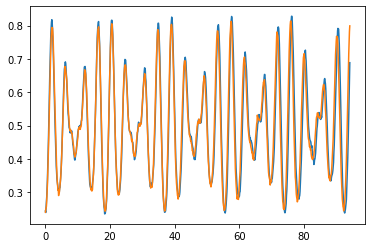

In [31]:
new_optimzed_guess = [ 0.42419006, -0.01593614, -0.48028082,  0.9896677 , -0.84485555, -0.70797138, -0.44130739,  0.26342375,  0.36292724 ]
em = EvolveModel(tt, rdm, init_params=new_optimzed_guess)
em.calcHam()
em.set_output_ts()
plt.plot(tt,np.real(rdm[:,0,0]))
plt.plot(tt,np.real(em.rdm_pred[:,0,0]))

We see that the 2-qubit Hamiltonian learning model reasonably approximates the data at un-seen future time-steps although at later times the agreement gets progressively less good compared to agreement on the initial training data trajectory.